In [3]:
import os, sys, urllib, gzip
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

In [4]:
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

C:\Users\Sylmarien\Anaconda3\envs\project8225\lib\site-packages\matplotlib\__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo
import theano

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Sylmarien/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.4-64/tmpq_nm1drv/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/Sylmarien/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.4-64/tmpq_nm1drv/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce GT 650M (CNMeM is disabled, CuDNN 4007)
C:\Users\Sylmarien\Anaconda3\envs\project8225\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [6]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
#try:
# pylearn2 version (fastest)
#from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
#from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
#print('Using cuda_convnet (faster)')
#except ImportError:
# gemm or cuDNN (if available, will be used)
from lasagne.layers import Conv2DLayer as Conv2DLayerFast
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
print('Using lasagne.layers (slower)')
# cuDNN (used by default if available)
#from lasagne.layers.dnn import Conv2DDNNLayer as Conv2DLayerFast
#from lasagne.layers.dnn import MaxPool2DDNNLayer as MaxPool2DLayerFast

In [7]:
fname = 'mnist/mnist.pkl.gz'
if not os.path.isfile(fname):
    try:
        testfile = urllib.request.URLopener()
    except:
        testfile = urllib.URLopener()
    testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
f = gzip.open(fname, 'rb')
try:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set = pickle.load(f)
f.close()
X, y = train_set

In [8]:
# reshape from (50000, 784) to 4D tensor (50000, 1, 28, 28)
X = X[0:1000]
X = np.reshape(X, (-1, 1, 28, 28))
print('X type and shape:', X.dtype, X.shape)
print('X.min():', X.min())
print('X.max():', X.max())

X type and shape: float32 (50000, 1, 28, 28)
X.min(): 0.0
X.max(): 0.996094


In [9]:
# we need our target to be 1 dimensional
X_out = X.reshape((X.shape[0], -1))
print('X_out:', X_out.dtype, X_out.shape)

X_out: float32 (50000, 784)


In [10]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 800}),
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 5, 5))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayerSlow, {'num_filters': 1, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [11]:
ae = NeuralNet(
    layers=layers,
    max_epochs=20,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

In [12]:
ae.fit(X, X_out)

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Sylmarien/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.4-64/tmpzfnxq4oa/mf560f8a69e507c154303564ff159a63e.lib and object C:/Users/Sylmarien/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.4-64/tmpzfnxq4oa/mf560f8a69e507c154303564ff159a63e.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Sylmarien/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.4-64/tmpaj7qnf6d/mb7677875a799bc853fe10227f08cde6c.lib and object C:/Users/Sylmarien/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.4.4-64/tmpaj7qnf6d/mb7677875a799bc853fe10227f08cde6c.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Sylmarien/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_58_Stepping_9_

# Neural Network with 224177 learnable parameters

## Layer information

  #  name           size
---  -------------  --------
  0  input0         1x28x28
  1  conv2ddnn1     16x26x26
  2  conv2ddnn2     16x24x24
  3  maxpool2ddnn3  16x12x12
  4  conv2ddnn4     32x10x10
  5  maxpool2ddnn5  32x5x5
  6  reshape6       800
  7  dense7         128
  8  encode         16
  9  dense9         128
 10  dense10        800
 11  reshape11      32x5x5
 12  upscale2d12    32x10x10
 13  conv2ddnn13    16x12x12
 14  upscale2d14    16x24x24
 15  conv2d15       16x26x26
 16  conv2d16       1x28x28
 17  reshape17      784

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.06693       0.05169      1.29496  63.50s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x0000000010F14E80>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x0000000010F14DA0>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.dnn.Conv2DDNNLayer'>, {'pad': 'valid', 'filter_size': 3, 'num_filters': 16}), (<class 'lasagne.layers.dnn.Conv2DDNNLayer'>, {'pad': 'valid', 'filter_size': 3, 'num_filters': 16}), (<class 'lasa...r_size': 3, 'num_filters': 1}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x0000000011027F28>,
     objective_loss_function=<function squared_error at 0x0000000010EA6378>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x000000001103A358>],
     on_training_finished=[],
 

<module 'matplotlib.pyplot' from 'C:\\Users\\Sylmarien\\Anaconda3\\envs\\project8225\\lib\\site-packages\\matplotlib\\pyplot.py'>

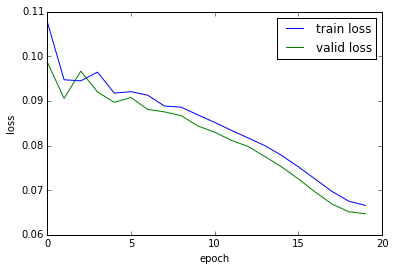

In [11]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

In [12]:
# ae.save_params_to('mnist/conv_ae.np')
pickle.dump(ae, open('mnist/conv_ae.pkl','wb'))
# ae = pickle.load(open('mnist/conv_ae.pkl','rb'))
# ae.layers

In [13]:
X_pred = ae.predict(X).reshape(-1, 28, 28)
X_pred = np.rint(256. * X_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print(X_pred.shape , X.shape)

(1000, 28, 28) (1000, 1, 28, 28)


In [14]:
!mkdir -p data
!mkdir -p montage

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file data already exists.
Error occurred while processing: data.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file montage already exists.
Error occurred while processing: montage.


2


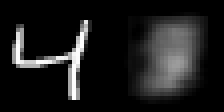

In [15]:
###  show random inputs / outputs side by side

def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(index):
    print(index)
    original_image = Image.fromarray(get_picture_array(255 * X[index]))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred[index]))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")
    return IPImage('data/test.png')

compare_images(2)
# compare_images(np.random.randint(50000))

In [31]:
## we find the encode layer from our ae, and use it to define an encoding function

def get_layer_by_name(net, name):
    for i, layer in enumerate(net.get_all_layers()):
        if layer.name == name:
            return layer, i
    return None, None
encode_layer, encode_layer_index = get_layer_by_name(ae, 'encode')

def encode_input(encode_layer, X):
    return get_output(encode_layer, inputs=X) #.eval() # Cause wrong type error

#X_encoded = encode_input(encode_layer, X)
input_layer, input_layer_index = get_layer_by_name(ae, 'input0')
f = theano.function([input_layer.input_var], get_output(encode_layer))
X_encoded = f(X[0:10000])

In [32]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

[  1 784]


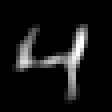

In [33]:
def get_output_from_nn(last_layer, X):
    return get_output(last_layer,X) #.eval() # Cause wrong type error

def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

X_decoded = 256 * decode_encoded_input(X_encoded[2])

X_decoded = X_decoded.eval()
X_decoded = theano.tensor.iround(X_decoded)
X_decoded = theano.tensor.clip(X_decoded, 0, 255)
X_decoded  = X_decoded.astype('uint8')
print(X_decoded.shape.eval())

pic_array = get_picture_array(X_decoded.eval())
image = Image.fromarray(pic_array)
image.save('data/test.png', format="PNG")  
IPImage('data/test.png')

In [34]:
enc_std = X_encoded.std(axis=0)
enc_mean = X_encoded.mean(axis=0)
enc_min = X_encoded.min(axis=0)
enc_max = X_encoded.max(axis=0)
m = X_encoded.shape[1]

In [35]:
n = 256
generated = np.random.normal(0, 1, (n, m)) * enc_std + enc_mean
generated = generated.astype(np.float32).clip(enc_min, enc_max)
X_decoded = decode_encoded_input(generated) * 256.
X_decoded = theano.tensor.iround(X_decoded )
X_decoded = theano.tensor.clip(X_decoded, 0, 255)
X_decoded  = X_decoded.astype('uint8')
!mkdir -p montage
for i in range(n):
    pic_array = get_picture_array(X_decoded[i].eval(), rescale=1)
    image = Image.fromarray(pic_array)
    image.save('montage/{0:03d}.png'.format(i), format='png')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file montage already exists.
Error occurred while processing: montage.


In [36]:
!montage -mode concatenate -tile 16x montage/*.png montage.png
IPImage('montage.png')

'montage' is not recognized as an internal or external command,
operable program or batch file.
